<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project_Bulk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models - Bulk RNAseq Analysis

## Notebook Setup

Run this cell every time the notebook is opened to mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If any import statements cannot be resolved, run this cell to re-install those packages.

In [ ]:
%pip install scanpy
%pip install anndata
%pip install igraph
%pip install pydeseq2
%pip install decoupler
%pip install gseapy
%pip install marsilea
%pip install adjustText
%pip install decoupler
%pip install omnipath

Import statements

In [ ]:
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import numpy as np
import pandas as pd
import decoupler as dc
import gc
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp

# Analysis on Ho et al bulk RNA-seq data

### Test out PyDESEq2 tutorial

See what the sample data + metadata looks like

In [ ]:
sample_counts_df = load_example_data(
    modality="raw_counts",
    dataset="synthetic",
    debug=False,
)

sample_counts_df.head()

In [ ]:
sample_metadata = load_example_data(
    modality="metadata",
    dataset="synthetic",
    debug=False,
)
sample_metadata.head()

,condition,group
sample1,A,X
sample2,A,Y
sample3,A,X
sample4,A,Y
sample5,A,X


## DEA on Ho et al data

### Data read-in and processing

First, we read in Ho et al bulk RNA-seq data, which is in the form of a gene-by-sample matrix within a .txt file. We then transpose this matrix into a sample-by-gene matrix, from which we then remove genes that are not expressed in at least 10 cells.

In [ ]:
#]Here, we read in the raw data via the pandas read_table method and save it as a dataframe.
counts_df = pd.read_table("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE210206_counts.txt", index_col=0, header=0)
counts_df.index.name = None
counts_df.head()

,OFO1003B1,OFO1003B2,OFO1003O1,OFO1003O2,OFO1003V1,OFO1003V2,OFO1004B1,OFO1004B2,OFO1004O1,OFO1004O2,OFO1004V1,OFO1004V2,OFO1005B1,OFO1005B2,OFO1005O1,OFO1005O2,OFO1005V1,OFO1005V2
DDX11L1,1,0,0,0,0,0,0,2,2,0,0,0,1,0,0,0,0,1
WASH7P,448,437,412,510,637,686,263,300,247,329,256,163,373,367,182,222,252,242
MIR6859-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MIR6859-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Now, we transpose the dataframe.
counts_df = counts_df.T
counts_df.head()

,DDX11L1,WASH7P,MIR6859-2,MIR6859-1,FAM138A,FAM138F,OR4F5,LOC729737,LOC100132287,LOC100133331,...,DAZ4,DAZ3,DAZ2,TTTY3B,TTTY3,CDY1B,CDY1,CSPG4P1Y,GOLGA2P3Y,GOLGA2P2Y
OFO1003B1,1,448,0,0,0,0,0,137,0,65,...,0,0,0,0,0,0,0,0,0,0
OFO1003B2,0,437,0,0,0,0,0,121,0,82,...,0,0,0,0,0,0,0,0,0,0
OFO1003O1,0,412,0,0,0,0,0,116,0,74,...,0,0,0,0,0,0,0,0,0,0
OFO1003O2,0,510,0,0,0,0,0,110,0,73,...,0,0,0,0,0,0,0,0,0,0
OFO1003V1,0,637,0,0,0,0,0,184,0,67,...,0,0,0,0,0,0,0,0,0,0


We will also drop buprenorphine samples from the counts and metadata tables since we are not considering those for our analysis.

In [ ]:
#We remove the buprenorphine samples from the dataframe using the drop method:
counts_df.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
counts_df

,DDX11L1,WASH7P,MIR6859-2,MIR6859-1,FAM138A,FAM138F,OR4F5,LOC729737,LOC100132287,LOC100133331,...,DAZ4,DAZ3,DAZ2,TTTY3B,TTTY3,CDY1B,CDY1,CSPG4P1Y,GOLGA2P3Y,GOLGA2P2Y
OFO1003O1,0,412,0,0,0,0,0,116,0,74,...,0,0,0,0,0,0,0,0,0,0
OFO1003O2,0,510,0,0,0,0,0,110,0,73,...,0,0,0,0,0,0,0,0,0,0
OFO1003V1,0,637,0,0,0,0,0,184,0,67,...,0,0,0,0,0,0,0,0,0,0
OFO1003V2,0,686,0,0,0,0,0,214,0,74,...,0,0,0,0,0,0,0,0,0,0
OFO1004O1,2,247,0,0,0,0,0,70,0,59,...,0,0,0,0,0,0,0,0,0,0
OFO1004O2,0,329,0,0,0,0,0,71,0,73,...,0,0,0,0,0,0,0,0,0,0
OFO1004V1,0,256,0,0,0,0,0,80,0,82,...,0,0,0,0,0,0,0,0,0,0
OFO1004V2,0,163,0,0,0,0,0,80,0,64,...,0,0,0,0,0,0,0,0,0,0
OFO1005O1,0,182,0,0,0,0,0,87,0,59,...,0,0,0,0,0,0,0,0,0,0
OFO1005O2,0,222,0,0,0,0,0,68,0,53,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Now, we filter the data s.t. genes which have counts less than 10 are removed from the dataframe.
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep].round()
print(f"Number of genes after filtering: {counts_df.shape[1]}")
counts_df.head()

Number of genes after filtering: 20060


,WASH7P,LOC729737,LOC100133331,MIR6723,LOC100288069,FAM87B,LINC00115,LINC01128,LOC100130417,SAMD11,...,NLGN4Y,NLGN4Y-AS1,NCRNA00185,TTTY14,CD24,BCORP1,TXLNGY,KDM5D,TTTY10,EIF1AY
OFO1003O1,412,116,74,51,34,3,50,206,38,28,...,121,4,15,8,3522,1,226,470,3,476
OFO1003O2,510,110,73,64,28,5,32,242,50,27,...,158,2,18,13,3924,1,233,569,2,560
OFO1003V1,637,184,67,46,47,6,108,427,62,43,...,234,5,17,25,5973,3,356,761,2,526
OFO1003V2,686,214,74,64,49,3,90,450,65,34,...,246,6,35,17,5883,1,345,767,9,488
OFO1004O1,247,70,59,66,39,4,37,224,33,51,...,402,4,34,31,7829,2,420,674,2,549


We will save the transposed and filtered `DataFrame` as a `.csv` file.

In [ ]:
#counts_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv")

### DEA on Ho dataset

Read in data

In [ ]:
ho_counts = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv", index_col=0)
#Drop buprenorphine samples
ho_counts.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)

Now, we read in our sample metadata and drop buprenorphine samples:

In [ ]:
metadata_Ho = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
#To maintain consistency, we drop buprenorphine samples from the metadata dataframe.
metadata_Ho.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
metadata_Ho

,condition,patient
OFO1003O1,oxycodone,3
OFO1003O2,oxycodone,3
OFO1003V1,PBS,3
OFO1003V2,PBS,3
OFO1004O1,oxycodone,4
OFO1004O2,oxycodone,4
OFO1004V1,PBS,4
OFO1004V2,PBS,4
OFO1005O1,oxycodone,5
OFO1005O2,oxycodone,5


Now that we have both the filtered counts and metadata saved as dataframes, we may use said dataframes to instantiate a DeseqDataSet object from the PyDESeq2 package.

In [ ]:
#Instantiating the DeseqDataSet object as "dds":
dds = DeseqDataSet(
    counts=ho_counts,
    metadata=metadata_Ho,
    design="~condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 27.49 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 37.62 seconds.

Fitting LFCs...
... done in 15.74 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



We now use the above DeseqDataSet object to instantiate a DeseqStats object, with which we'll use to perform our statistical tests (i.e. Wald Tests) upon our count data.

In [ ]:
#Instantiating the Deseqs object as "dds":
ds = DeseqStats(dds, contrast=["condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        334.891714       -0.023777  0.375434 -0.063331  0.949503   
LOC729737     101.279831       -0.254941  0.326969 -0.779710  0.435561   
LOC100133331   65.896619        0.085467  0.180021  0.474763  0.634956   
MIR6723        57.464911        0.003456  0.224056  0.015425  0.987693   
LOC100288069   41.061355        0.042128  0.188033  0.224048  0.822720   
...                  ...             ...       ...       ...       ...   
TXLNGY        376.443449       -0.024936  0.203437 -0.122572  0.902446   
KDM5D         667.987542       -0.058664  0.087404 -0.671180  0.502106   
TTTY10          2.966215       -0.770596  0.671624 -1.147363  0.251232   
EIF1AY        635.048811        0.292607  0.217881  1.342965  0.179283   
RPS4Y2          0.753348        1.187694  1.495

... done in 6.49 seconds.



In [ ]:
#The results of the aforementioned tests are then exported to a separate dataframe object, "ds_df".
ds_df = ds.results_df
ds_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
WASH7P,334.891714,-0.023777,0.375434,-0.063331,0.949503,0.992853
LOC729737,101.279831,-0.254941,0.326969,-0.779710,0.435561,0.876079
LOC100133331,65.896619,0.085467,0.180021,0.474763,0.634956,0.921971
MIR6723,57.464911,0.003456,0.224056,0.015425,0.987693,0.998943
LOC100288069,41.061355,0.042128,0.188033,0.224048,0.822720,0.967234
...,...,...,...,...,...,...
TXLNGY,376.443449,-0.024936,0.203437,-0.122572,0.902446,0.984533
KDM5D,667.987542,-0.058664,0.087404,-0.671180,0.502106,0.893179
TTTY10,2.966215,-0.770596,0.671624,-1.147363,0.251232,NaN


In [ ]:
#We then save this dataframe as a .csv so that, when troubleshooting the later
#steps, we need not re-run the above analyses.
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_unfiltered.csv")

In [ ]:
#Now, we shrink our LFC results.
ds.lfc_shrink(coeff="condition[T.oxycodone]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.oxycodone]
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
WASH7P        334.891714       -0.000888  0.102896 -0.063331  0.949503   
LOC729737     101.279831       -0.013166  0.100527 -0.779710  0.435561   
LOC100133331   65.896619        0.013080  0.093931  0.474763  0.634956   
MIR6723        57.464911        0.000388  0.096535  0.015425  0.987693   
LOC100288069   41.061355        0.005949  0.093151  0.224048  0.822720   
...                  ...             ...       ...       ...       ...   
TXLNGY        376.443449       -0.003009  0.094784 -0.122572  0.902446   
KDM5D         667.987542       -0.026039  0.069875 -0.671180  0.502106   
TTTY10          2.966215       -0.010009  0.100630 -1.147363  0.251232   
EIF1AY        635.048811        0.034604  0.112413  1.342965  0.179283   
RPS4Y2          0.753348        0.003211  0.

... done in 54.54 seconds.



In [ ]:
#We overwrite the data within the ds_df object with the results of the above
#LFC shrinkage:
ds_df = ds.results_df
ds_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
WASH7P,334.891714,-0.000888,0.102896,-0.063331,0.949503,0.992853
LOC729737,101.279831,-0.013166,0.100527,-0.779710,0.435561,0.876079
LOC100133331,65.896619,0.013080,0.093931,0.474763,0.634956,0.921971
MIR6723,57.464911,0.000388,0.096535,0.015425,0.987693,0.998943
LOC100288069,41.061355,0.005949,0.093151,0.224048,0.822720,0.967234
...,...,...,...,...,...,...
TXLNGY,376.443449,-0.003009,0.094784,-0.122572,0.902446,0.984533
KDM5D,667.987542,-0.026039,0.069875,-0.671180,0.502106,0.893179
TTTY10,2.966215,-0.010009,0.100630,-1.147363,0.251232,NaN


Compare to Kim DEGs

In [ ]:
#To allow us to compare the two datasets, we read-in the earleir-computed DEGs
#from the Kim dataset so that we need not re-run its analysis.
kim_degs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_sc_degs.csv", index_col=0)
kim_degs_df = kim_degs_df[(kim_degs_df["pvals_adj"] < 0.05) & (abs(kim_degs_df["logfoldchanges"]) > 1)].copy()
kim_degs_df

,scores,logfoldchanges,pvals,pvals_adj
names,,,,
COL2A1,47.570698,5.832469,0.000000e+00,0.000000e+00
COL9A3,43.402985,6.282064,0.000000e+00,0.000000e+00
MATN3,38.707294,7.012120,0.000000e+00,0.000000e+00
COL9A1,38.610733,5.302363,0.000000e+00,0.000000e+00
CNMD,38.597767,7.358423,0.000000e+00,0.000000e+00
...,...,...,...,...
MPC1,-28.582235,-1.342400,1.117223e-179,7.448154e-178
HES6,-29.196468,-1.297069,2.150084e-187,1.743312e-185
CLU,-29.212036,-1.309093,1.363870e-187,1.136558e-185


In [ ]:
#We create a list variable of the indeces of the Kim dataframe,
#instantiated above. This will be used in creating a figure later.
kim_degs = kim_degs_df.index.tolist()
print(kim_degs[:10])

['COL2A1', 'COL9A3', 'MATN3', 'COL9A1', 'CNMD', 'COL11A1', 'SCRG1', 'HAPLN1', 'SNORC', 'COL11A2']


In [ ]:
#We then pair-down the Ho et al results dataframe to include only the DEGs with
#an FDR (i.e. padj value) < 0.1 & an |LFC| > 0.5.
ho_degs_df = ds_df[(abs(ds_df["log2FoldChange"]) > 0.5) & (ds_df["padj"] < 0.1)].copy()
#We then create a list of said dataframe's indeces.
ho_degs = ho_degs_df.index.tolist()
print(ho_degs[:10])

['CLDN19', 'CYP4X1', 'BARHL2', 'GCLM', 'SFT2D2', 'F5', 'KCNH1', 'TMEM72', 'PRAP1', 'CDKN1C']


In [ ]:
#We then save the intersection of respective sets of the Kim and Ho DEG indeces
#as the "common degs" set, which is then converted to a list as well.
common_degs = set(kim_degs) & set(ho_degs)
common_degs = list(common_degs)
print(common_degs[:10])
print(len(common_degs))

['BARHL2', 'COL2A1']
2


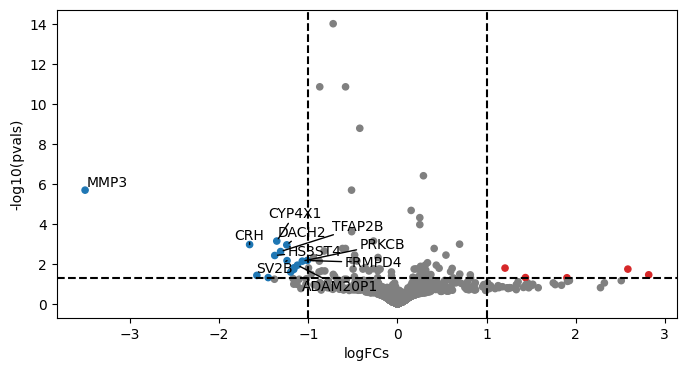

In [ ]:
#We now plot the original results dataframe (before thresholds were applied) as
#a volcano plot.
dc.plot_volcano_df(
    ds_df,
    x='log2FoldChange',
    y='padj',
    lFCs_thr=1,
    top=10,
    figsize=(8, 4)
)

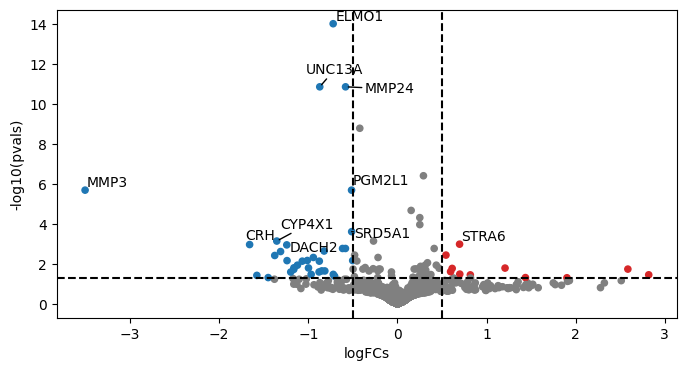

In [ ]:
#Replotted volcano plot, with the LFC threshold decreased from 1 to 0.5.
dc.plot_volcano_df(
    ds_df,
    x='log2FoldChange',
    y='padj',
    lFCs_thr=0.5,
    top=10,
    figsize=(8, 4)
)

In [ ]:
ds_df = ds.results_df
ds_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
WASH7P,334.891714,-0.000888,0.102896,-0.063331,0.949503,0.992853
LOC729737,101.279831,-0.013166,0.100527,-0.779710,0.435561,0.876079
LOC100133331,65.896619,0.013080,0.093931,0.474763,0.634956,0.921971
MIR6723,57.464911,0.000388,0.096535,0.015425,0.987693,0.998943
LOC100288069,41.061355,0.005949,0.093151,0.224048,0.822720,0.967234
...,...,...,...,...,...,...
TXLNGY,376.443449,-0.003009,0.094784,-0.122572,0.902446,0.984533
KDM5D,667.987542,-0.026039,0.069875,-0.671180,0.502106,0.893179
TTTY10,2.966215,-0.010009,0.100630,-1.147363,0.251232,NaN


In [ ]:
#We once again save the DEGs as a separate .csv file.
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_unfiltered_shrank.csv")

In [ ]:
#We further filter our DEGs via removing those with a padj value of less than 0.05.
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
ds_df_filtered = ds_df[ds_df["padj"] <= 0.05]
ds_df_filtered

In [ ]:
#ds_df_filtered.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_filtered_DEGs_2.csv")

In [ ]:
ds_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2.csv", index_col=0)
ds_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,15.308486,3.380426,0.889235,3.801501,1.438224e-04,0.035580
TMEM72,21.251279,3.010617,0.744152,4.045704,5.216611e-05,0.018401
LOC101927023,6.331255,2.307839,0.630486,3.660412,2.518103e-04,0.049981
PTGER2,29.153726,1.750784,0.477185,3.668983,2.435177e-04,0.048963
AGPAT9,111.170314,1.396165,0.339573,4.111527,3.930511e-05,0.016364
...,...,...,...,...,...,...
CDH18,65.885447,-1.771623,0.482594,-3.671040,2.415653e-04,0.048963
CRH,59.134253,-1.826382,0.372641,-4.901185,9.526018e-07,0.001084
NWD2,107.381842,-1.899834,0.503656,-3.772086,1.618887e-04,0.037940


In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
ds_df = ds_df[ds_df["padj"] <= 0.05]
ds_df.index.name = "gene_symbol"
ho_degs = ds_df
ho_degs.reset_index()

,gene_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,SLC22A8,15.308486,2.820128,0.930517,3.801501,1.438224e-04,0.035580
1,TMEM72,21.251279,2.586040,0.771357,4.045704,5.216611e-05,0.018401
2,LOC101927023,6.331255,1.902382,0.641543,3.660412,2.518103e-04,0.049981
3,PTGER2,29.153726,1.436707,0.501707,3.668983,2.435177e-04,0.048963
4,AGPAT9,111.170314,1.207697,0.352482,4.111527,3.930511e-05,0.016364
...,...,...,...,...,...,...,...
81,HS3ST4,82.946158,-1.376877,0.351125,-4.549464,5.378272e-06,0.003825
82,CDH18,65.885447,-1.450321,0.517678,-3.671040,2.415653e-04,0.048963
83,NWD2,107.381842,-1.577427,0.537271,-3.772086,1.618887e-04,0.037940
84,CRH,59.134253,-1.658825,0.383610,-4.901185,9.526018e-07,0.001084


In [ ]:
# ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_shrank.csv")

### ORA on Ho et al dataset

Here, we perform ORA upon the Ho et al data.

In [ ]:
#First, we read in the DEGs which were previously discovered within the Ho et al
#data and saved as an external .csv file.
ho_degs = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_unfiltered_shrank.csv", index_col=0)
ho_degs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
WASH7P,334.891714,-0.000888,0.102896,-0.063331,0.949503,0.992853
LOC729737,101.279831,-0.013166,0.100527,-0.779710,0.435561,0.876079
LOC100133331,65.896619,0.013080,0.093931,0.474763,0.634956,0.921971
MIR6723,57.464911,0.000388,0.096535,0.015425,0.987693,0.998943
LOC100288069,41.061355,0.005949,0.093151,0.224048,0.822720,0.967234
...,...,...,...,...,...,...
TXLNGY,376.443449,-0.003009,0.094784,-0.122572,0.902446,0.984533
KDM5D,667.987542,-0.026039,0.069875,-0.671180,0.502106,0.893179
TTTY10,2.966215,-0.010009,0.100630,-1.147363,0.251232,NaN


ORA functions

In [ ]:
def filter_degs_df(degs_df, padj_threshold=0.05, lfc_threshold=0.5, filter_cell_cycle_genes=True):
  """
  Given a PyDESeq2 results dataframe of DEGs, a maximum p-adj value (e.g. 0.05),
  and a positive log2FC threshold (e.g. 0.25), return a filtered dataframe.
  """
  if degs_df.empty:
    return degs_df
  # Here, we filter DEGs by p-value and log fold change
  degs_df = degs_df[(degs_df['padj'] < padj_threshold) & (abs(degs_df['log2FoldChange']) > lfc_threshold)].copy()
  # Here, we filter out cell cycle genes
  with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GO cell cycle genes.txt", "r") as f:
    cell_cycle_genes = f.read().strip().split(",")
  degs_df = degs_df[~degs_df.index.isin(cell_cycle_genes)].copy()
  # Here, we filter out ribosomal and mitochondrial genes
  degs_df = degs_df[~degs_df.index.str.startswith(("RPS", "RPL", "MT-"))].copy()
  return degs_df

def get_up_down_degs(degs_df):
  """
  Given a filtered PyDESeq2 results dataframe of DEGs, return lists of upregulated
  and downregulated DEGs.
  """
  if degs_df.empty:
    return [], []
  gene_list = degs_df.index.tolist()
  degs_up = degs_df[degs_df['log2FoldChange'] > 0].index.tolist()
  degs_down = degs_df[degs_df['log2FoldChange'] < 0].index.tolist()
  return degs_up, degs_down

def run_ora(degs_up, degs_down, gene_set: str):
  # Function executes an ORA with a single gene set
  up = gp.enrichr(gene_list=degs_up, gene_sets=gene_set, organism="human", outdir=None)
  down = gp.enrichr(gene_list=degs_down, gene_sets=gene_set, organism="human", outdir=None)
  up_df, down_df = up.results, down.results
  return up_df, down_df

def filter_ora_results(ora_df, padj_threshold=0.05, min_genes=1):
  #Handling empty dataframes:
  if ora_df.empty:
    return ora_df
  #Now, we apply thresholds:
  ora_df = ora_df[
      (ora_df['Adjusted P-value'] < padj_threshold) &
      (ora_df["Overlap"].apply(lambda x: int(x.split("/")[0]) >= min_genes))
      ].copy()
  if ora_df.empty:
    return ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']]
  #Then, we round our values
  ora_df.loc[:, 'Adjusted P-value'] = ora_df['Adjusted P-value'].round(4).copy()
  ora_df.loc[:, 'Odds Ratio'] = ora_df['Odds Ratio'].round(1).copy()
  ora_df.loc[:, 'Combined Score'] = ora_df['Combined Score'].round().copy()
  #Finally, we sort and filter
  ora_df.copy().sort_values('Combined Score', ascending=False, inplace=True)
  ora_df = ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']].copy()
  return ora_df

Try with less strict thresholds (FDR < 0.1, |LFC| > 0.5)

In [ ]:
ds_df = filter_degs_df(ho_degs, padj_threshold=0.1, lfc_threshold=0.5)
ds_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
CLDN19,115.088716,1.461269,0.600265,3.381911,7.198341e-04,0.090431
CYP4X1,37.186848,-1.354014,0.302609,-5.015500,5.289569e-07,0.000723
GCLM,223.829100,0.596971,0.221379,3.528363,4.181376e-04,0.067977
SFT2D2,38.484464,0.612811,0.219991,3.583731,3.387209e-04,0.059345
F5,155.059114,1.930050,0.739334,3.512200,4.444141e-04,0.069598
...,...,...,...,...,...,...
FRMPD4,50.045664,-1.011293,0.268704,-4.401289,1.076098e-05,0.006803
DACH2,41.327722,-1.241919,0.287476,-4.881093,1.054997e-06,0.001126
IRS4,66.860703,1.354240,0.531962,3.449708,5.611930e-04,0.079170


In [ ]:
degs_up, degs_down = get_up_down_degs(ds_df)
print(f"{len(degs_up)} upregulated genes: {degs_up}")
print(f"{len(degs_down)} downregulated genes: {degs_down}")

30 upregulated genes: ['CLDN19', 'GCLM', 'SFT2D2', 'F5', 'TMEM72', 'AMPD3', 'SLC22A8', 'COL2A1', 'BRI3BP', 'PTGER2', 'ELL3', 'STRA6', 'TLCD2', 'SPTLC3', 'C22orf15', 'TIMP3', 'BHLHE40', 'SI', 'ATP13A5', 'NSUN7', 'AGPAT9', 'OSMR', 'LOC101927023', 'ARHGAP18', 'AQP1', 'PDLIM2', 'STC1', 'WDR34', 'IRS4', 'MOSPD1']
45 downregulated genes: ['CYP4X1', 'KCNH1', 'RIC3', 'PGM2L1', 'MMP3', 'FAM19A2', 'NTS', 'FAM155A', 'ADAM20P1', 'SV2B', 'HS3ST4', 'CPNE7', 'OMG', 'ZFR2', 'UNC13A', 'LINC01123', 'C2orf80', 'NGEF', 'MMP24', 'CACNA1I', 'CNTN4', 'ITPR1-AS1', 'SYN2', 'ZNF385D', 'FAM19A1', 'FGF12', 'PPP2R2C', 'NWD2', 'SRD5A1', 'CDH18', 'CDH10', 'GABRG2', 'TFAP2B', 'NKAIN2', 'RGS17', 'ELMO1', 'ADCY1', 'EPHB6', 'KEL', 'EN2', 'CRH', 'SAMD12', 'FRMPD4', 'DACH2', 'TENM1']


In [ ]:
up_df, down_df = run_ora(degs_up, degs_down, "GO_Biological_Process_2023")

In [ ]:
up_filtered = filter_ora_results(up_df, padj_threshold=0.1, min_genes=2)
up_filtered

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes
0,Cellular Response To Ketone (GO:1901655),0.0993,33.9,211.0,2/44,PTGER2;AQP1
1,Blood Circulation (GO:0008015),0.0993,29.6,177.0,2/50,GCLM;F5
2,Embryonic Organ Development (GO:0048568),0.0993,18.9,97.0,2/77,COL2A1;STRA6
15,Calcium Ion Homeostasis (GO:0055074),0.0993,14.2,65.0,2/102,ATP13A5;STC1
33,Response To Cytokine (GO:0034097),0.0993,11.5,48.0,2/125,TIMP3;OSMR
39,Circulatory System Development (GO:0072359),0.0993,10.9,45.0,2/132,PDLIM2;STRA6
40,Negative Regulation Of Cell Motility (GO:2000146),0.0993,10.8,44.0,2/133,CLDN19;STC1
46,Intracellular Calcium Ion Homeostasis (GO:0006...,0.0993,10.3,41.0,2/139,ATP13A5;STC1
53,Skeletal System Development (GO:0001501),0.0993,9.6,37.0,2/149,COL2A1;STC1
57,Negative Regulation Of Cell Migration (GO:0030...,0.0993,8.8,33.0,2/163,CLDN19;STC1


In [ ]:
down_filtered = filter_ora_results(down_df, padj_threshold=0.05, min_genes=5)
down_filtered

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes
1,Cell-Cell Adhesion Via Plasma-Membrane Adhesio...,0.0053,14.8,150.0,5/172,TENM1;MMP24;CDH10;CNTN4;CDH18
2,Chemical Synaptic Transmission (GO:0007268),0.0307,9.2,73.0,5/273,RIC3;UNC13A;CRH;SYN2;GABRG2


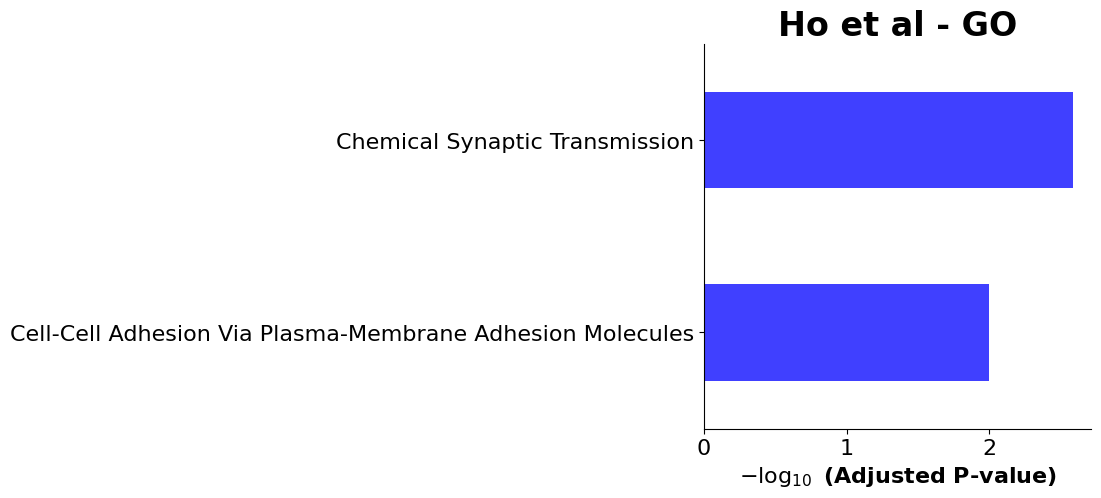

In [ ]:
down_filtered.Term = down_filtered.Term.str.split(" \(GO").str[0]
ax = gp.barplot(down_filtered, figsize=(5,5),
                title ="Ho et al - GO",
                color = 'b')

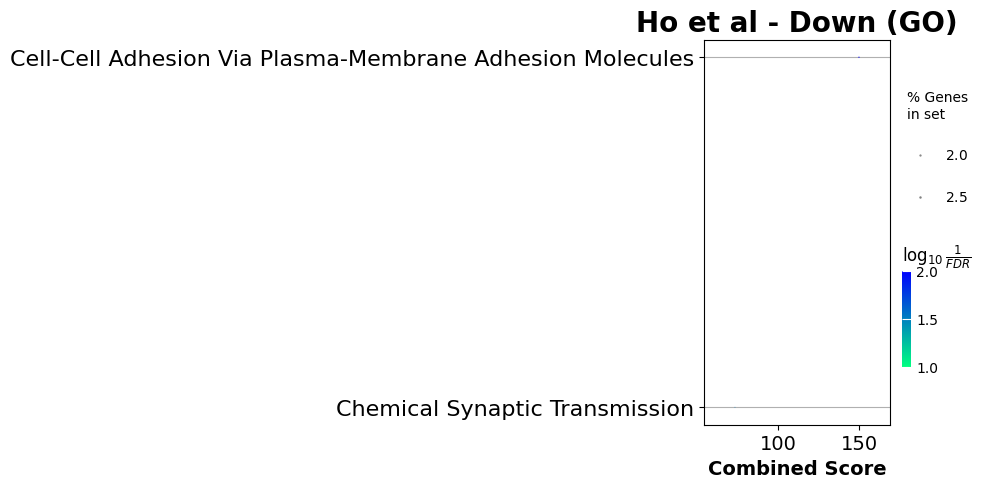

In [ ]:
# trim (go:...)
down_filtered.Term = down_filtered.Term.str.split(" \(GO").str[0]
gp.dotplot(down_filtered, figsize=(3,5), title="Ho et al - Down (GO)", cmap = plt.cm.winter_r, size=5)
plt.show()

In [ ]:
up_df, down_df = run_ora(degs_up, degs_down, "MSigDB_Hallmark_2020")

In [ ]:
up_filtered = filter_ora_results(up_df, padj_threshold=0.1, min_genes=2)
up_filtered

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes
0,Hypoxia,0.0688,11.2,64.0,3/200,BHLHE40;STC1;AMPD3


In [ ]:
down_filtered = filter_ora_results(down_df, padj_threshold=0.1, min_genes=3)
down_filtered

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [ ]:
up_df, down_df = run_ora(degs_up, degs_down, "KEGG_2021_Human")

In [ ]:
up_filtered = filter_ora_results(up_df, padj_threshold=0.1, min_genes=2)
up_filtered

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [ ]:
down_filtered = filter_ora_results(down_df, padj_threshold=0.1, min_genes=3)
down_filtered

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


### ORA with FDR < 0.05 and |LFC| > 1

Filter DEGs

In [ ]:
ho_degs_filtered = filter_degs_df(ho_degs, lfc_threshold=1)
ho_degs_filtered.loc[:, 'log2FoldChange'] = ho_degs_filtered['log2FoldChange'].round(2).copy()
ho_degs_filtered[['log2FoldChange']]

,log2FoldChange
gene_symbol,
SLC22A8,2.82
TMEM72,2.58
PTGER2,1.44
AGPAT9,1.21
FRMPD4,-1.01
ADAM20P1,-1.12
CNTN4,-1.16
EN2,-1.16
NKAIN2,-1.20


In [ ]:
ho_degs_filtered = filter_degs_df(ho_degs, lfc_threshold=0.5)
ho_degs_filtered.loc[:, 'log2FoldChange'] = ho_degs_filtered['log2FoldChange'].round(2).copy()
ho_degs_filtered[['log2FoldChange']]

,log2FoldChange
gene_symbol,
SLC22A8,2.82
TMEM72,2.58
PTGER2,1.44
AGPAT9,1.21
TIMP3,0.82
AMPD3,0.70
STRA6,0.70
BRI3BP,0.61
MOSPD1,0.60


Get upregulated and downregulated DEGs

In [ ]:
ho_degs_filtered = filter_degs_df(ho_degs, lfc_threshold=1)
ho_up, ho_down = get_up_down_degs(ho_degs_filtered)
print(f"upregulated DEGS: {ho_up}")
print(f"downregulated DEGS: {ho_down}")

upregulated DEGS: ['SLC22A8', 'TMEM72', 'PTGER2', 'AGPAT9']
downregulated DEGS: ['FRMPD4', 'ADAM20P1', 'CNTN4', 'EN2', 'NKAIN2', 'SV2B', 'DACH2', 'TFAP2B', 'CYP4X1', 'HS3ST4', 'CDH18', 'NWD2', 'CRH', 'MMP3']


Run ORA with Gene Ontology (GO) Database

In [ ]:
ho_up_go, ho_down_go = run_ora(ho_up, ho_down, "GO_Biological_Process_2023")

In [ ]:
filter_ora_results(ho_up_go, min_genes=3)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [ ]:
filter_ora_results(ho_down_go, min_genes=3)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


Run ORA with GSEA Molecular Signatures (MSig) Database

In [ ]:
ho_up_msig, ho_down_msig = run_ora(ho_up, ho_down, "MSigDB_Hallmark_2020")

In [ ]:
filter_ora_results(ho_up_msig, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [ ]:
filter_ora_results(ho_down_msig, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


Run ORA with KEGG

In [ ]:
ho_up_kegg, ho_down_kegg = run_ora(ho_up, ho_down, "KEGG_2021_Human")

In [ ]:
filter_ora_results(ho_up_kegg, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [ ]:
filter_ora_results(ho_down_kegg, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


### GSEA on Ho et al data

In [ ]:
ho_counts = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv", index_col=0)
ho_counts.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
ho_counts.head()

,WASH7P,LOC729737,LOC100133331,MIR6723,LOC100288069,FAM87B,LINC00115,LINC01128,FAM41C,LOC100130417,...,NLGN4Y-AS1,NCRNA00185,TTTY14,CD24,BCORP1,TXLNGY,KDM5D,TTTY10,EIF1AY,RPS4Y2
OFO1003O1,412,116,74,51,34,3,50,206,0,38,...,4,15,8,3522,1,226,470,3,476,0
OFO1003O2,510,110,73,64,28,5,32,242,1,50,...,2,18,13,3924,1,233,569,2,560,1
OFO1003V1,637,184,67,46,47,6,108,427,0,62,...,5,17,25,5973,3,356,761,2,526,0
OFO1003V2,686,214,74,64,49,3,90,450,0,65,...,6,35,17,5883,1,345,767,9,488,0
OFO1004O1,247,70,59,66,39,4,37,224,0,33,...,4,34,31,7829,2,420,674,2,549,0


In [ ]:
ho_metadata = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
#We remove the buprenorphine samples via drop method
ho_metadata.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
ho_metadata.head()

,condition,patient
OFO1003O1,oxycodone,3
OFO1003O2,oxycodone,3
OFO1003V1,PBS,3
OFO1003V2,PBS,3
OFO1004O1,oxycodone,4


In [ ]:
ho_conditions = ho_metadata["condition"].tolist()
print(ho_conditions)

['oxycodone', 'oxycodone', 'PBS', 'PBS', 'oxycodone', 'oxycodone', 'PBS', 'PBS', 'oxycodone', 'oxycodone', 'PBS', 'PBS']


Perform GSEA with GO Database

In [ ]:
gsea_ho_go = gp.gsea(
    data=ho_counts.T, # row -> genes, column-> samples
    gene_sets="GO_Biological_Process_2023",
    cls=ho_conditions,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [ ]:
gsea_ho_go_res = gsea_ho_go.res2d.head()
gsea_ho_go_res.head(1)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Rac Protein Signal Transduction (GO:0016601),-0.759336,-2.026456,0.002004,0.472839,0.056,7/15,8.97%,ELMO1;CDH13;EPS8;RAC1;RAC3;WASF1;HACE1


Filter by FDR < 0.05

In [ ]:
gsea_ho_go_res_005 = gsea_ho_go_res[gsea_ho_go_res["FDR q-val"] < 0.05].copy()
gsea_ho_go_res_005

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Filter by FDR < 0.1

In [ ]:
gsea_ho_go_res_01 = gsea_ho_go_res[gsea_ho_go_res["FDR q-val"] < 0.1].copy()
gsea_ho_go_res_01

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Perform GSEA with MSig Database

In [ ]:
gsea_ho_msig = gp.gsea(
    data=ho_counts.T, # row -> genes, column-> samples
    gene_sets="MSigDB_Hallmark_2020",
    cls=ho_conditions,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [ ]:
gsea_ho_msig_res = gsea_ho_msig.res2d.head()
gsea_ho_msig_res.head(1)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Hedgehog Signaling,-0.503434,-1.495018,0.026,1.0,0.393224,18/35,29.05%,THY1;RTN1;SCG2;ACHE;PLG;DPYSL2;L1CAM;CRMP1;CDK...


Filter by FDR < 0.05

In [ ]:
gsea_ho_msig_res_005 = gsea_ho_msig_res[gsea_ho_msig_res["FDR q-val"] < 0.05].copy()
gsea_ho_msig_res_005

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Filter by FDR < 0.1

In [ ]:
gsea_ho_msig_res_01 = gsea_ho_msig_res[gsea_ho_msig_res["FDR q-val"] < 0.1].copy()
gsea_ho_msig_res_01

Perform GSEA with KEGG database

In [ ]:
gsea_ho_kegg = gp.gsea(
    data=ho_counts.T, # row -> genes, column-> samples
    gene_sets="KEGG_2021_Human",
    cls=ho_conditions,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [ ]:
gsea_ho_kegg_res = gsea_ho_kegg.res2d.head()
gsea_ho_kegg_res.head(1)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,GABAergic synapse,-0.619242,-1.862755,0.002004,0.657932,0.12012,43/87,19.09%,GABRA4;PRKCB;ADCY1;GABRA5;GABRA6;GABRB1;GNG2;G...


Filter by FDR < 0.05

In [ ]:
gsea_ho_kegg_res_005 = gsea_ho_kegg_res[gsea_ho_kegg_res["FDR q-val"] < 0.05].copy()
gsea_ho_kegg_res_005

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Filter by FDR < 0.1

In [ ]:
gsea_ho_kegg_res_01 = gsea_ho_kegg_res[gsea_ho_kegg_res["FDR q-val"] < 0.1].copy()
gsea_ho_kegg_res_01

### Transcription factor inference on Ho et al data

Read in data

In [ ]:
ho_degs = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_shrank.csv", index_col=0)
ho_degs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,15.308486,2.817224,0.932700,3.793968,1.482588e-04,0.034898
TMEM72,21.251279,2.584398,0.772771,4.039238,5.362518e-05,0.017478
PTGER2,29.153726,1.435954,0.502241,3.665597,2.467621e-04,0.049201
AGPAT9,111.170314,1.207840,0.352367,4.112698,3.910624e-05,0.015413
TIMP3,1170.655814,0.818615,0.269459,3.801038,1.440911e-04,0.034395
...,...,...,...,...,...,...
HS3ST4,82.946158,-1.376833,0.351059,-4.550232,5.358670e-06,0.003633
CDH18,65.885447,-1.449823,0.518081,-3.668774,2.437159e-04,0.049173
NWD2,107.381842,-1.577144,0.537516,-3.770679,1.628038e-04,0.037286


We will use the obtained gene level statistics to perform enrichment analysis. We will use the t-values instead of logFCs since t-values incorporate the significance of change in their value. We will transform the obtained t-values stored in stats to a wide matrix so that it can be used by decoupler:

In [ ]:
mat = ho_degs[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

gene_symbol,SLC22A8,TMEM72,PTGER2,AGPAT9,TIMP3,AMPD3,STRA6,BRI3BP,MOSPD1,WDR34,CDKN1C,MSRB1,ICT1,GYS1,GSR,SERF2,PRMT7,EXOSC4,CD63,PUF60,HEG1,MRPL33,GAPDH,POLR2J,KIF15,CIB1,VKORC1,P4HB,ECI2,SRI,SEPT2,PPIB,GOSR2,SLC35A4,HDLBP,BARHL2,EIF4E1B,MRAS,TSC1,UBE2H,EPS15,AASDHPPT,CD200,TMCC1,CTC1,MIR4697HG,MOXD1,YWHAH,FAM155B,MIR600HG,HRH3,OSBPL6,NGEF,SRD5A1,PGM2L1,MMP24,SAMD12,RIC3,KCNH1,NTS,ELMO1,PPP2R2C,EPHB6,ADCY1,UNC13A,FGF12,ZNF385D,SYN2,CACNA1I,TENM1,FRMPD4,PRKCB,ADAM20P1,CNTN4,EN2,NKAIN2,SV2B,DACH2,TFAP2B,CYP4X1,HS3ST4,CDH18,NWD2,CRH,MMP3
treatment.vs.control,3.793968,4.039238,3.665597,4.112698,3.801038,3.84473,4.935717,4.099788,3.933272,4.581402,4.114061,4.23338,4.794578,3.82912,3.681152,3.748448,4.31972,4.010565,3.786086,4.243897,3.68874,4.00579,6.49191,3.820295,4.019952,4.205212,5.451596,5.608056,3.807267,4.095784,4.877711,4.089103,3.706166,3.726556,5.795417,-3.755605,-3.904772,-4.065883,-4.060561,-4.513537,-3.983802,-3.705224,-5.04235,-4.10066,-3.970338,-4.160743,-4.056482,-7.306381,-4.38125,-4.589521,-3.731669,-4.053289,-4.404998,-5.263882,-6.181959,-7.98885,-4.779224,-4.789213,-3.745595,-3.83344,-8.951955,-3.953665,-4.70266,-3.965014,-7.947878,-4.359572,-3.911021,-4.498269,-3.82659,-4.123836,-4.403934,-4.351844,-4.220279,-4.130926,-4.019894,-3.903746,-4.383792,-4.882539,-4.673738,-5.015921,-4.550232,-3.668774,-3.770679,-4.900326,-6.134244


CollecTRI is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. We can use decoupler to retrieve it from omnipath.

In [ ]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


To infer TF enrichment scores we will run the Univariate Linear Model (ulm) method. For each sample in our dataset (mat) and each TF in our network (net), it fits a linear model that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 85 targets for 6 sources.


,ESR1,JUN,MYC,NFKB,PGR,SP1
treatment.vs.control,1.838113,-1.388597,2.660969,0.079626,1.172428,2.509246


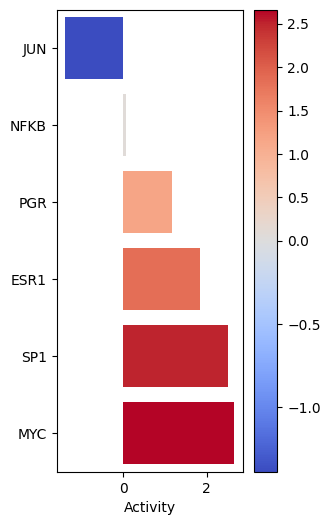

In [ ]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=25,
    vertical=True,
    figsize=(3, 6),
)

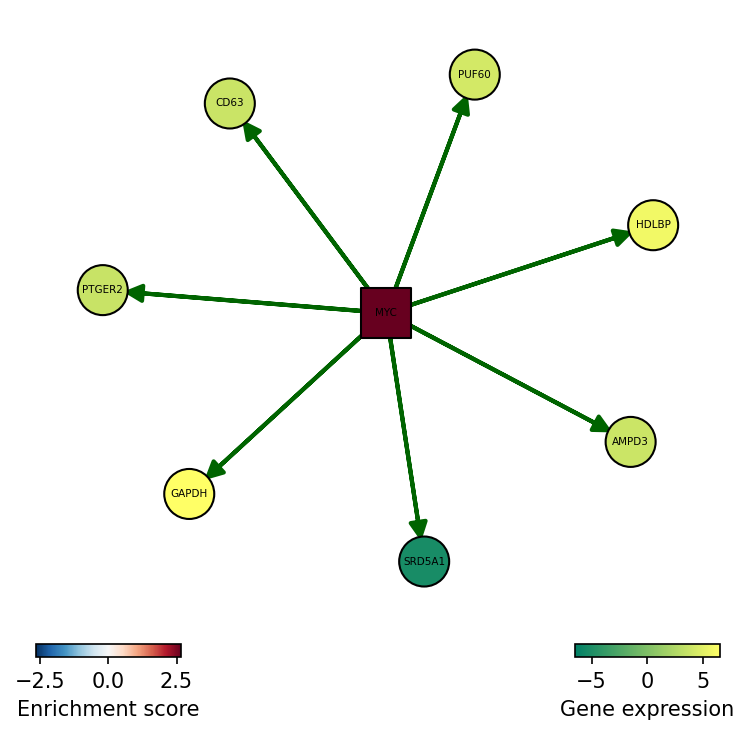

In [ ]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYC'],
    n_targets=15,
    node_size=50,
    figsize=(5, 5),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True,
    t_cmap='summer'
)

Another analysis we can perform is to infer pathway activities from our transcriptomics data. PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

In [ ]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

0.00B [00:00, ?B/s]

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (mlm) method. For each sample in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [ ]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 85 targets for 2 sources.


,Hypoxia,TGFb
treatment.vs.control,2.370358,-0.840037


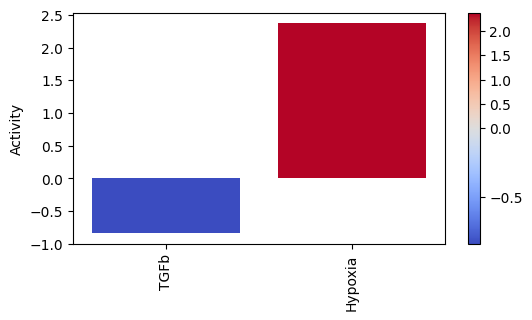

In [ ]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

Let us plot the obtained scores for the top active/inactive transcription factors: